In [1]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.DataFrame()

for i in range(10):
    file_name = f'{i}_processed.parquet'
    file_path = f'D:/mashob/data/{file_name}'
    df_cur = pq.read_table(source=file_path).to_pandas()
    df = pd.concat([df, df_cur])

In [4]:
df.head(3)

,title,text_markdown,pluses,minuses,id,author_id,username,url,tags
7,рассада,аня волос нос расти петя аня жопа рассада петя...,5,14,2936217,453525,Misochkin,https://pikabu.ru/story/rassada_2936217,Петр;Анна;Рассада;Волосы;Текст;Переписка;Знако...
11,начальник обед,родственница жаловаться дурдом работа трудитьс...,681,40,6991412,1699826,FluffyMagpie,https://pikabu.ru/story/pro_nachalnikov_i_obed...,Начальник;Руководитель;Обед;Еда;Сотрудники;Текст
15,помогать поиск игра,добрый сутки господин дама подсказывать назван...,2,10,6991359,878346,Keeeesha,https://pikabu.ru/story/pomogite_pozhaluysta_p...,Игры;Мобильное приложение;Гонки;Без рейтинга;П...


In [5]:
len(df)

71626

# Filtered data

Find index of those rows in which the pluses or minuses are not the real value

In [6]:
filtered_df = df[~(((df['minuses'] == 0) & (df['pluses'] == 0)) | (df['minuses'] < 0) | (df['pluses'] < 0))].copy()

In [7]:
len(filtered_df)

67999

In [8]:
def wilson_score(pluses: int, minuses: int, eps: float = 1e-7) -> float:
    n = pluses + minuses
    if n == 0:
        return 0
    p = pluses / (n + eps)
    return _wilson_score(p, n)

def _wilson_score(p: int, n: int) -> float:
    q = 1.96
    return (p + q**2 / (2*n) - q*np.sqrt((p*(1 - p) + q**2/(4*n)) / n)) / (1 + q**2/n)

In [9]:
filtered_df['rating'] = filtered_df.apply(lambda row: wilson_score(row['pluses'], row['minuses']), axis=1)

In [10]:
pd.isnull(filtered_df.rating).count()

67999

Text(0, 0.5, 'Number of posts')

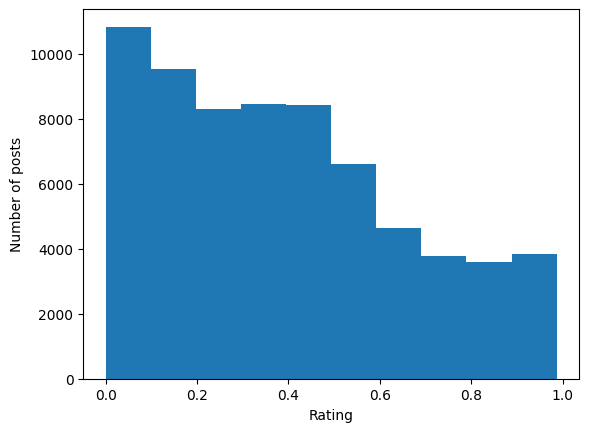

In [10]:
plt.hist(filtered_df.rating)
plt.xlabel('Rating')
plt.ylabel('Number of posts')

# To predict the rating: values ​​​​from 0 to 1, we solve the regression problem

# Gradient Boosting

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df.text_markdown, filtered_df.rating, test_size=0.2, random_state=42)

In [13]:
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [14]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector = v.fit_transform(X_train_text)
X_test_vector = v.transform(X_test_text)

In [20]:
params = {'n_estimators':500,
          'max_depth':5,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16,
          'random_state':42,
          }

In [21]:
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train_vector, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_leaf=16,
                          min_samples_split=16, n_estimators=500,
                          random_state=42)

In [22]:
train_accuracy_score=gbr.score(X_train_vector,y_train)
print(train_accuracy_score)

0.2468420132220529


In [23]:
test_accuracy_score=gbr.score(X_test_vector,y_test)
print(test_accuracy_score)

0.17009233809381819


In [24]:
y_pred = gbr.predict(X_test_vector)

In [25]:
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_grad_boost = r2_score(y_test,y_pred)
print("R^2: ", r2_grad_boost)

RMSE: 0.24
R^2:  0.17009233809381819


# Catboost

In [27]:
from catboost import CatBoostRegressor

In [27]:
catboost_model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=6,
                          random_state=42)

In [28]:
catboost_model.fit(X_train_vector, y_train, eval_set=(X_test_vector, y_test))

0:	learn: 0.2650049	test: 0.2645832	best: 0.2645832 (0)	total: 195ms	remaining: 3m 14s
1:	learn: 0.2632717	test: 0.2628471	best: 0.2628471 (1)	total: 233ms	remaining: 1m 56s
2:	learn: 0.2616772	test: 0.2612979	best: 0.2612979 (2)	total: 267ms	remaining: 1m 28s
3:	learn: 0.2603246	test: 0.2600161	best: 0.2600161 (3)	total: 299ms	remaining: 1m 14s
4:	learn: 0.2591332	test: 0.2588692	best: 0.2588692 (4)	total: 329ms	remaining: 1m 5s
5:	learn: 0.2580988	test: 0.2579000	best: 0.2579000 (5)	total: 360ms	remaining: 59.6s
6:	learn: 0.2572628	test: 0.2570713	best: 0.2570713 (6)	total: 399ms	remaining: 56.6s
7:	learn: 0.2564986	test: 0.2563665	best: 0.2563665 (7)	total: 441ms	remaining: 54.6s
8:	learn: 0.2556950	test: 0.2556312	best: 0.2556312 (8)	total: 473ms	remaining: 52.1s
9:	learn: 0.2549179	test: 0.2548478	best: 0.2548478 (9)	total: 505ms	remaining: 50s
10:	learn: 0.2542883	test: 0.2542071	best: 0.2542071 (10)	total: 538ms	remaining: 48.4s
11:	learn: 0.2537261	test: 0.2536584	best: 0.25365

In [29]:
y_pred = catboost_model.predict(X_test_vector)

In [30]:
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_cat_boost = r2_score(y_test,y_pred)
print("R^2: ", r2_cat_boost)

RMSE: 0.24
R^2:  0.18413901744126282


# Let features = 'tags'

In [31]:
X_train_tags, X_test_tags, y_train, y_test = train_test_split(filtered_df.tags, filtered_df.rating, test_size=0.2, random_state=42)

In [32]:
X_train_text_tags = X_train_tags.values
X_test_text_tags = X_test_tags.values
y_train = y_train.values
y_test = y_test.values

In [33]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector_tags = v.fit_transform(X_train_text_tags)
X_test_vector_tags = v.transform(X_test_text_tags)

In [34]:
params = {'n_estimators':500,
          'max_depth':10,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16,
          'random_state':42,
          }

In [35]:
gbr_tags = GradientBoostingRegressor(**params)
gbr_tags.fit(X_train_vector_tags, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=16,
                          min_samples_split=16, n_estimators=500,
                          random_state=42)

In [36]:
train_accuracy_score=gbr_tags.score(X_train_vector_tags,y_train)
print(train_accuracy_score)

0.19184765744552978


In [37]:
test_accuracy_score=gbr_tags.score(X_test_vector_tags,y_test)
print(test_accuracy_score)

0.16081683058829477


In [38]:
y_pred = gbr_tags.predict(X_test_vector_tags)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
print("R^2: ", r2_score(y_test,y_pred))

RMSE: 0.24
R^2:  0.16081683058829477


# Use w2v to create embeddings

model Word2Vec from Gensim.

In [12]:
from gensim.models import Word2Vec

In [13]:
w2v_model = Word2Vec(min_count=10, window=2, vector_size=300, negative=10, alpha=0.03, min_alpha=0.0007, sample=6e-5, sg=1)

### Create function for splitting the text of each row into words

In [14]:
import pandas as pd
import re

def get_vocab(text: pd.core.series.Series) -> list:
    stop_words = ['тот', 'который', 'которая']
    words = re.findall(r'\w+', text.lower())
    filtered_words = [word for word in words if not re.match(r'^[a-zA-Z]+$', word) and word not in stop_words]
    return filtered_words

In [15]:
data = filtered_df.text_markdown.apply(get_vocab)

In [16]:
data

7        [аня, волос, нос, расти, петя, аня, жопа, расс...
11       [родственница, жаловаться, дурдом, работа, тру...
15       [добрый, сутки, господин, дама, подсказывать, ...
23       [негр, ходить, больница, читать, рэп, едит, ин...
28       [жук, мужик, российский, ржаной, гречневый, ал...
                               ...                        
22982                  [неужели, плохо, хотеть, дискотека]
22983    [ставить, копейка, обида, школьный, учитель, т...
22986    [слушать, история, клиент, магазин, модный, од...
22987    [интернет, проходить, конкурс, машинный, обуче...
22998    [слышать, мероприятие, название, одесса, прохо...
Name: text_markdown, Length: 67999, dtype: object

In [17]:
w2v_model.build_vocab(data)

In [18]:
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(159529960, 227273130)

In [58]:
w2v_model.save("word2vec.model")

In [19]:
w2v_model.wv.most_similar(positive=["политика"])

[('олигархический', 0.3984033167362213),
 ('очернение', 0.39096179604530334),
 ('тема', 0.38584280014038086),
 ('либерализм', 0.38567081093788147),
 ('украина', 0.3850327730178833),
 ('экономика', 0.38063308596611023),
 ('страна', 0.3774896264076233),
 ('религия', 0.3766276240348816),
 ('русофобский', 0.3711170554161072),
 ('россия', 0.3680931031703949)]

In [20]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, filtered_df.rating, test_size=0.2, random_state=42)
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
train_tdidf = tfidf_vectorizer(w2v).fit(X_train_text).transform(X_train_text)

In [24]:
test_tdidf = tfidf_vectorizer(w2v).fit(X_test_text).transform(X_test_text)

In [25]:
test_tdidf.shape[0] + train_tdidf.shape[0] == len(filtered_df.text_markdown)

True

In [62]:
params = {'n_estimators':500,
          'max_depth':5,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':32,
          'min_samples_split':32,
          'random_state':42,
          }

In [63]:
gbr_w2v = GradientBoostingRegressor(**params)
gbr_w2v.fit(train_tdidf, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_leaf=32,
                          min_samples_split=32, n_estimators=500,
                          random_state=42)

In [64]:
y_pred = gbr_w2v.predict(test_tdidf)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_grad_boost_w2v = r2_score(y_test,y_pred)
print("R^2: ", r2_grad_boost_w2v)

RMSE: 0.24
R^2:  0.21145011730756547


Value R^2 increased by 0.0258 due to use of word2vec to obtain embeddings.

##### Now let`s train catboostRegressor on our embeddings.

In [34]:
catboost_model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.07,
                          depth=6,
                          random_state=42)

catboost_model.fit(train_tdidf, y_train, eval_set=(test_tdidf, y_test))

0:	learn: 0.2651837	test: 0.2647825	best: 0.2647825 (0)	total: 97.6ms	remaining: 1m 37s
1:	learn: 0.2634871	test: 0.2631122	best: 0.2631122 (1)	total: 149ms	remaining: 1m 14s
2:	learn: 0.2621189	test: 0.2617475	best: 0.2617475 (2)	total: 200ms	remaining: 1m 6s
3:	learn: 0.2608203	test: 0.2604898	best: 0.2604898 (3)	total: 253ms	remaining: 1m 3s
4:	learn: 0.2595508	test: 0.2592434	best: 0.2592434 (4)	total: 318ms	remaining: 1m 3s
5:	learn: 0.2583598	test: 0.2580562	best: 0.2580562 (5)	total: 383ms	remaining: 1m 3s
6:	learn: 0.2572871	test: 0.2569681	best: 0.2569681 (6)	total: 449ms	remaining: 1m 3s
7:	learn: 0.2562692	test: 0.2559125	best: 0.2559125 (7)	total: 510ms	remaining: 1m 3s
8:	learn: 0.2553312	test: 0.2549812	best: 0.2549812 (8)	total: 566ms	remaining: 1m 2s
9:	learn: 0.2544251	test: 0.2540892	best: 0.2540892 (9)	total: 623ms	remaining: 1m 1s
10:	learn: 0.2536210	test: 0.2532819	best: 0.2532819 (10)	total: 682ms	remaining: 1m 1s
11:	learn: 0.2528799	test: 0.2525338	best: 0.2525

In [35]:
y_pred = catboost_model.predict(test_tdidf)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_cat_boost_w2v = r2_score(y_test,y_pred)
print("R^2: ", r2_cat_boost_w2v)

RMSE: 0.24
R^2:  0.21945196266745692


Value R^2 increased by 0.0127 due to use of word2vec to obtain embeddings

# R^2

In [36]:
index = ['without word2vec', 'with word2vec']
data_table = {'GradientBoosting': [r2_grad_boost, r2_grad_boost_w2v],
              'CatBoost': [r2_cat_boost, r2_cat_boost_w2v]}

df_r2 = pd.DataFrame(data_table, index=index)
print(df_r2)

                  GradientBoosting  CatBoost
without word2vec          0.170092  0.184139
with word2vec             0.211450  0.219452
